In [ ]:
import torch
from torch import nn, Tensor
from tqdm import tqdm
from transformers import AutoTokenizer
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from metrics.perplexity import preprocess, calculate_perplexity
from metrics.lm_eval import eval_lambda

device = "cuda:7" if torch.cuda.is_available() else "cpu"

In [2]:
model_path = "/home/boboxa/llm_inference/llama3.2-3b"

model = AutoModelForCausalLM.from_pretrained(model_path).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")

data = preprocess(dataset['text'], tokenizer, device)

In [7]:
ppl_model = calculate_perplexity(model, data, tokenizer, model.device, 512)

100%|██████████| 564/564 [01:55<00:00,  4.89it/s]


In [8]:
acc_model = eval_lambda(model, tokenizer, device)

bootstrapping for stddev: perplexity


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 74.13it/s]


In [9]:
acc_model['results']

{'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 3.942507905471055,
  'perplexity_stderr,none': 0.08280548598854429,
  'acc,none': 0.7054143217543178,
  'acc_stderr,none': 0.006350969451144858},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 4.905349989192083,
  'perplexity_stderr,none': 0.11454508235768332,
  'acc,none': 0.6425383271880458,
  'acc_stderr,none': 0.006676922474252461}}

In [10]:
from transformers import BitsAndBytesConfig

llm8bit_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model_llm8bit = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=llm8bit_config, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
ppl_model_llm8bit = calculate_perplexity(model_llm8bit, data, tokenizer, model_llm8bit.device, 512)

100%|██████████| 564/564 [01:17<00:00,  7.26it/s]


In [12]:
acc_model_llm8bit = eval_lambda(model_llm8bit, tokenizer, device)

`pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
Running loglikelihood requests: 100%|██████████| 10306/10306 [22:19<00:00,  7.70it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:01<00:00, 75.65it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:01<00:00, 72.66it/s]


In [13]:
acc_model_llm8bit['results']

{'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 4.041938507230418,
  'perplexity_stderr,none': 0.08540700024237048,
  'acc,none': 0.7005627789637104,
  'acc_stderr,none': 0.006380996322762499},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 5.054216974580822,
  'perplexity_stderr,none': 0.11863459491832151,
  'acc,none': 0.634775858723074,
  'acc_stderr,none': 0.006708138364946148}}

In [14]:
from transformers import BitsAndBytesConfig

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False
)
model_nf4 = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=nf4_config, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
ppl_model_nf4 = calculate_perplexity(model_nf4, data, tokenizer, model_nf4.device, 512)

  0%|          | 0/564 [00:00<?, ?it/s]/home/boboxa/myenv/lib/python3.10/site-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
100%|██████████| 564/564 [02:01<00:00,  4.66it/s]


In [16]:
acc_model_nf4 = eval_lambda(model_nf4, tokenizer, device)

`pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
Running loglikelihood requests: 100%|██████████| 10306/10306 [12:42<00:00, 13.52it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:01<00:00, 76.19it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARAL

bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:01<00:00, 61.41it/s]


In [22]:
acc_model_nf4['results']

{'lambada_openai': {'alias': 'lambada_openai',
  'perplexity,none': 4.13047145223225,
  'perplexity_stderr,none': 0.08849086997420616,
  'acc,none': 0.7050261983310693,
  'acc_stderr,none': 0.006353403285409047},
 'lambada_standard': {'alias': 'lambada_standard',
  'perplexity,none': 5.466358082431764,
  'perplexity_stderr,none': 0.13234650155241406,
  'acc,none': 0.6233262177372404,
  'acc_stderr,none': 0.006750756859146703}}

In [18]:
from transformers import BitsAndBytesConfig

fp4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="fp4",
    bnb_4bit_use_double_quant=False
)
model_fp4 = AutoModelForCausalLM.from_pretrained(model_path, quantization_config=fp4_config, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
ppl_model_fp4 = calculate_perplexity(model_fp4, data, tokenizer, model_fp4.device, 512)

100%|██████████| 564/564 [01:58<00:00,  4.74it/s]


In [ ]:
acc_model_fp4 = eval_lambda(model_fp4, tokenizer, device)

In [41]:
acc_model_fp4['results']['lambada_openai']['acc,none']

0.6563167087133709

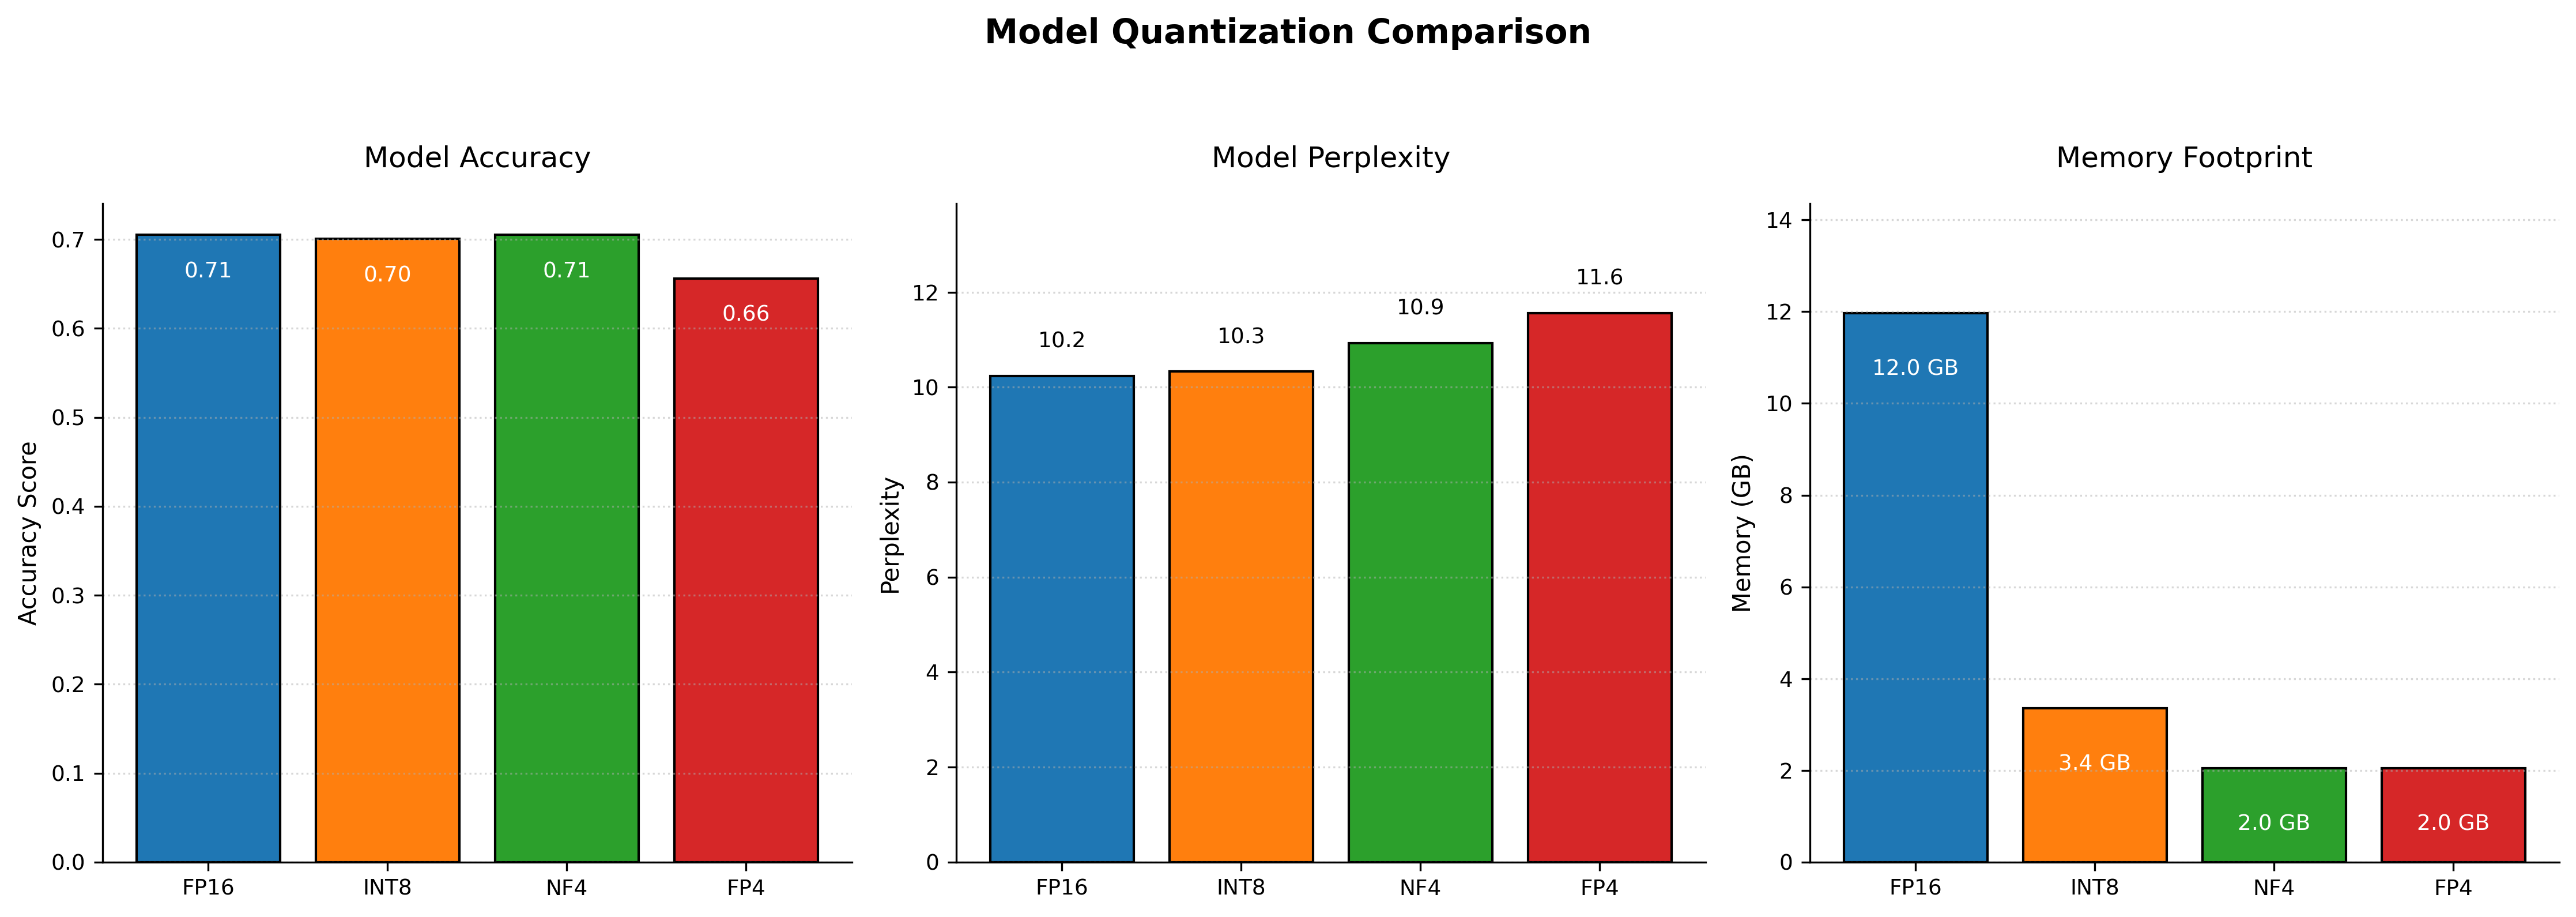

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dtypes = ['FP16', 'INT8', 'NF4', 'FP4']
metrics = {
    'Accuracy': [
        acc_model['results']['lambada_openai']['acc,none'],
        acc_model_llm8bit['results']['lambada_openai']['acc,none'],
        acc_model_nf4['results']['lambada_openai']['acc,none'],
        acc_model_fp4['results']['lambada_openai']['acc,none']
        ],
    'Perplexity': [ppl_model, ppl_model_llm8bit, ppl_model_nf4, ppl_model_fp4], 
    'Memory (GB)': [model.get_memory_footprint() / 1024**3,
                    model_llm8bit.get_memory_footprint() / 1024**3,
                    model_nf4.get_memory_footprint() / 1024**3,
                    model_fp4.get_memory_footprint()/ 1024**3
                    ]
}


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=300)
plt.subplots_adjust(wspace=0.3)


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


bars1 = ax1.bar(dtypes, metrics['Accuracy'], color=colors, edgecolor='black')
ax1.set_title('Model Accuracy', pad=15, fontsize=12)
ax1.set_ylabel('Accuracy Score', fontsize=10)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height-0.03,
             f'{height:.2f}',
             ha='center', va='top', color='white', fontsize=9)


bars2 = ax2.bar(dtypes, metrics['Perplexity'], color=colors, edgecolor='black')
ax2.set_title('Model Perplexity', pad=15, fontsize=12)
ax2.set_ylabel('Perplexity', fontsize=10)
ax2.set_ylim(0, max(metrics['Perplexity'])*1.2)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height+0.5,
             f'{height:.1f}',
             ha='center', va='bottom', fontsize=9)


bars3 = ax3.bar(dtypes, metrics['Memory (GB)'], color=colors, edgecolor='black')
ax3.set_title('Memory Footprint', pad=15, fontsize=12)
ax3.set_ylabel('Memory (GB)', fontsize=10)
ax3.set_ylim(0, max(metrics['Memory (GB)'])*1.2)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height-1,
             f'{height:.1f} GB',
             ha='center', va='top', color='white', fontsize=9)


for ax in [ax1, ax2, ax3]:
    ax.grid(axis='y', linestyle=':', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.suptitle('Model Quantization Comparison', y=1.05, fontsize=14, fontweight='bold')
plt.tight_layout()

# Save
plt.savefig('model_comparison_triple.png', bbox_inches='tight', dpi=300)
plt.savefig('model_comparison_triple.pdf', bbox_inches='tight')
plt.show()